<a href="https://colab.research.google.com/github/Pterjudin/Diagnosis_of_psychiatric_diseases_from_brain_MRI_data/blob/main/THE_EARLY_DIAGNOSIS_OF_PSYCHIATRIC_DISEASES_FROM_BRAIN_MRI_DATA_USING_3D_CNN_v_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EARLY DIAGNOSIS OF PSYCHIATRIC DISEASES FROM BRAIN MRI DATA USING 3D CNN

---



**Author:** [Tajudeen Oyindamola Tajudeen](https://www.linkedin.com/in/tajudeen-oyindamola/)<br>
**Date created:** 2021/08/23<br>
**Last modified:** 2021/09/09<br>
**Description:** Train a 3D convolutional neural network to diagnose brain disease from MRI scans.


## Reference

- [3D image classification from CT scans](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/3D_image_classification.ipynb#scrollTo=HWLscW0iu7n9)

- [Classification on imbalanced data](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb#scrollTo=7JfLUlawto_D)



## Loading the Dataset And Importing needed libraries.

I will be using 3D MRI scans to build a 3-D CNN to diagnose psychiatric diseases from the scans. Hence, the task is a binary classification problem. The data is loaded from google drive and needed libraries are loaded as below. 



In [1]:
# This code block mounts my google drive where I have the given dataset.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
####################################IMPORTING THE NEEDED LIBRARIES#######################################################
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import zipfile
import tempfile
############################################TENSORFLOW IMPORTS#########################################################
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [3]:
# Link to the Zip File provided
zipped_data = '/content/drive/MyDrive/MRI_Data.zip'
base_dir_for_data = os.getcwd()
# Unzipping the file
with zipfile.ZipFile(zipped_data,"r") as zip_ref:
    zip_ref.extractall(base_dir_for_data)
# Checking if my file are correctly loaded
arr = os.listdir(base_dir_for_data)

## Data Preprocessing And Exploratory Data Analysis.

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. The labels are available in a different CSV file. The column of interest in the CSV file is the `Diagnosis` column. This column has values 0 - HC, 1 - Schizophrenia, 2 - Psychotic Disorder, 3 - Unspecified psychotic disorder, 4 - Schizophreniform disorder, 5 - Schizoaffective disorder, 6 - SIP, 7 - Bipolar disorder. Since we have a binary classification problem, we combine classes 1 - 7 as a single class. 

In [4]:
# Loading the labels
data_df=pd.read_excel('/content/MRI_Data/Classification_clean.xlsx')
data_df["Class"] = data_df["Diagnosis"] > 0
data_df["Class"] = data_df["Class"].astype('float64')
# Declaring the Labels
labels = data_df["Class"]
# Taking a quick look at the dataset.
data_df.head(10) 

,ID_CF,FirstEpisodes_FEP__HealthyControl_HC_,Diagnosis,Gender,Age,Site 1,Site 2,Site 3,Site 4,Site 5,Site 6,Site 7,Euler,Class
0,CF_001,FEP,3,0,23.857632,0,0,0,0,0,0,0,-21,1.0
1,CF_002,FEP,3,0,28.952772,0,0,0,0,0,0,0,-33,1.0
2,CF_003,FEP,1,0,20.199863,0,0,0,0,0,0,0,-55,1.0
3,CF_004,FEP,1,0,28.517454,0,0,0,0,0,0,0,-26,1.0
4,CF_005,FEP,2,1,39.101985,0,0,0,0,0,0,0,-24,1.0
5,CF_007,FEP,4,1,24.043806,0,0,0,0,0,0,0,-32,1.0
6,CF_008,FEP,4,1,23.808350,0,0,0,0,0,0,0,-32,1.0
7,CF_009,FEP,1,0,28.908966,0,0,0,0,0,0,0,-41,1.0
8,CF_010,FEP,3,0,29.404517,0,0,0,0,0,0,0,-27,1.0
9,CF_011,FEP,5,1,24.763860,0,0,0,0,0,0,0,-28,1.0


Start of EDA

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID_CF                                  674 non-null    object 
 1   FirstEpisodes_FEP__HealthyControl_HC_  674 non-null    object 
 2   Diagnosis                              674 non-null    int64  
 3   Gender                                 674 non-null    int64  
 4   Age                                    674 non-null    float64
 5   Site 1                                 674 non-null    int64  
 6   Site 2                                 674 non-null    int64  
 7   Site 3                                 674 non-null    int64  
 8   Site 4                                 674 non-null    int64  
 9   Site 5                                 674 non-null    int64  
 10  Site 6                                 674 non-null    int64  
 11  Site 7

In [6]:
# Checking for Data Imbalances.
data_df['Class'].value_counts()

0.0    451
1.0    223
Name: Class, dtype: int64

The O class is slightly two times the 1 class. Thus, the data is imbalanced.

In [7]:
# Getting number of data point belonging to the 0 and 1 classes.
num_zeros_class, num_ones_class = data_df['Class'].value_counts()[0], data_df['Class'].value_counts()[1]
print(num_zeros_class, num_ones_class)

451 223


In [8]:
from scipy import ndimage

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan
# Since the images are already normalized, we only convert the datatype to float32 and scale the data
def normalize(volume):
    """Normalize the volume"""
    volume = volume.astype("float32")
    volume /= 255
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


Load Data from path using the helper functions.



In [9]:
# Loading and processing the normalized mri scans
mri_data_path = [
    os.path.join(os.getcwd(), "/content/MRI_Data/normalized/", x)
    for x in os.listdir("/content/MRI_Data/normalized/") 
]
mri_scans = np.array([process_scan(path) for path in mri_data_path])

Splitting the Dataset into train and test datasets.

In [10]:
# Splitting the Dataset into Train and Test Datasets using a test dataset that is 33% of the original data.
X_train, X_test, y_train, y_test = train_test_split(mri_scans, labels, test_size=0.33, shuffle=True)

In [11]:
def train_preprocessing(volume, label):
    """Adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size = 5
# Generating train Dataset
train_dataset = (
    train_loader.shuffle(len(X_train)).map(train_preprocessing).batch(batch_size).prefetch(5)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test)).map(validation_preprocessing).batch(batch_size).prefetch(5)
)



Visualize an augmented MRI scan.

Dimension of the MRI scan is: (128, 128, 64, 1)


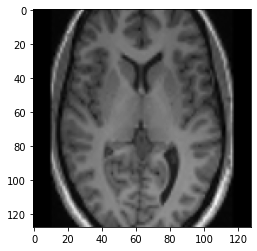

In [12]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


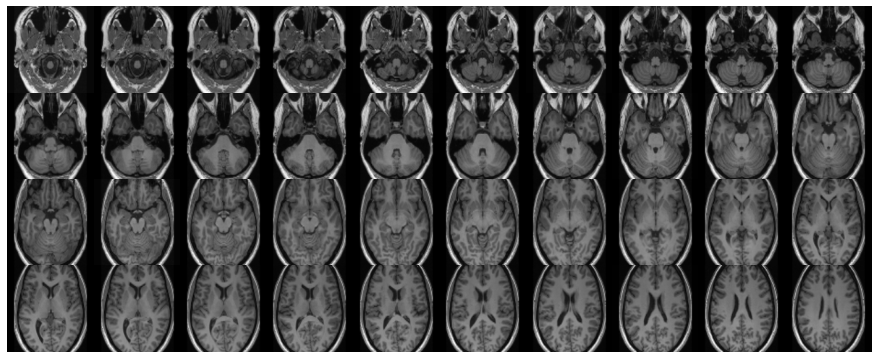

In [13]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()
plot_slices(4, 10, 128, 128, image[:, :, :40])

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of the classes.


 Since the dataset is imbalanced, an output layer is set bias to reflect that which can help with initial convergence.


 The default bias initialization the loss should be about math.log(2) = 0.69314, and the correct bias could be gotten using the equation below.

 $$ p_0 = HCs /(FEP + HC) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(FEP/HC)$$

Where FEP = First Episodes Patients </br>
HC = Healthy Controls </br>

Setting the initial bias make the model give reasonable initial guesses. 

These guesses should be near: `number of HCs/total = 0.3308`

In [14]:
initial_bias = np.log([num_ones_class/num_zeros_class])
initial_bias

array([-0.70429557])

In [15]:
def get_model(width=128, height=128, depth=64, output_bias = initial_bias):
    """Build a 3D convolutional neural network model."""
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid", bias_initializer= output_bias)(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      ]
      # Compile model.
    model.compile(
            loss="binary_crossentropy",
            optimizer=keras.optimizers.Adam(learning_rate=0.00001),
            metrics=METRICS,
        )
    return model


# Build model.
model = get_model(width=128, height=128, depth=64, output_bias = initial_bias)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 32)  896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

### Creating initial weights checkpoints

Keep this initial model's weights in a checkpoint file to make the various training runs more comparable, and load them into each model before training:

In [16]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### To check if setting initial bias helps


In [17]:
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    batch_size=10,
    shuffle=True,
    verbose=1,
)

Epoch 1/5
91/91 [==============================] - 45s 289ms/step - loss: 0.6646 - tp: 15.0000 - fp: 29.0000 - tn: 276.0000 - fn: 131.0000 - accuracy: 0.6452 - precision: 0.3409 - recall: 0.1027 - auc: 0.4934 - prc: 0.3205 - val_loss: 0.8282 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 145.0000 - val_fn: 77.0000 - val_accuracy: 0.6502 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5538 - val_prc: 0.3735
Epoch 2/5
91/91 [==============================] - 25s 273ms/step - loss: 0.6385 - tp: 18.0000 - fp: 22.0000 - tn: 283.0000 - fn: 128.0000 - accuracy: 0.6674 - precision: 0.4500 - recall: 0.1233 - auc: 0.5564 - prc: 0.3686 - val_loss: 1.1456 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 145.0000 - val_fn: 77.0000 - val_accuracy: 0.6502 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5347 - val_prc: 0.3646
Epoch 3/5
91/91 [==============================] - 25s 279ms/step - loss: 0.6523 - tp: 10.0000 - fp: 20.0000 - tn: 285.0000 - fn: 136.0000 - a

In [18]:
model = get_model(width=128, height=128, depth=64, output_bias = initial_bias)
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
careful_bias_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    batch_size=10,
    shuffle=True,
    verbose=1,
)

Epoch 1/5
91/91 [==============================] - 29s 298ms/step - loss: 0.6765 - tp: 15.0000 - fp: 30.0000 - tn: 275.0000 - fn: 131.0000 - accuracy: 0.6430 - precision: 0.3333 - recall: 0.1027 - auc: 0.4722 - prc: 0.3081 - val_loss: 0.9490 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 145.0000 - val_fn: 77.0000 - val_accuracy: 0.6502 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5541 - val_prc: 0.3758
Epoch 2/5
91/91 [==============================] - 26s 289ms/step - loss: 0.6565 - tp: 7.0000 - fp: 16.0000 - tn: 289.0000 - fn: 139.0000 - accuracy: 0.6563 - precision: 0.3043 - recall: 0.0479 - auc: 0.4776 - prc: 0.3145 - val_loss: 1.0783 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 145.0000 - val_fn: 77.0000 - val_accuracy: 0.6502 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5477 - val_prc: 0.3698
Epoch 3/5
91/91 [==============================] - 26s 289ms/step - loss: 0.6492 - tp: 9.0000 - fp: 12.0000 - tn: 293.0000 - fn: 137.0000 - acc

In [19]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               label='Train ' + label, color= 'g')
  plt.semilogy(history.epoch, history.history['val_loss'],
               label='Val ' + label,
               color= 'r', linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


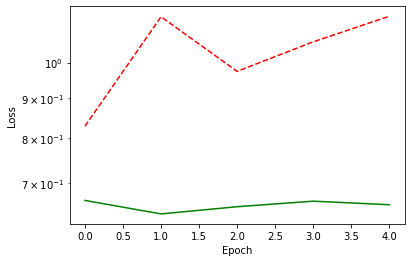

In [20]:
plot_loss(zero_bias_history, "Zero Bias", 0)


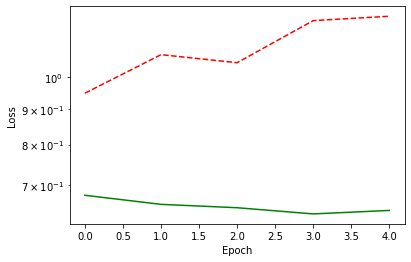

In [21]:
plot_loss(careful_bias_history, "Careful Bias", 1)

## Train model

In [22]:
# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
91/91 - 26s - loss: 0.6453 - tp: 4.0000 - fp: 11.0000 - tn: 294.0000 - fn: 142.0000 - accuracy: 0.6608 - precision: 0.2667 - recall: 0.0274 - auc: 0.5095 - prc: 0.3256 - val_loss: 0.7424 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 145.0000 - val_fn: 77.0000 - val_accuracy: 0.6502 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4824 - val_prc: 0.3473
Epoch 2/100
91/91 - 26s - loss: 0.6507 - tp: 10.0000 - fp: 13.0000 - tn: 292.0000 - fn: 136.0000 - accuracy: 0.6696 - precision: 0.4348 - recall: 0.0685 - auc: 0.5203 - prc: 0.3507 - val_loss: 1.5609 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 145.0000 - val_fn: 77.0000 - val_accuracy: 0.6502 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5368 - val_prc: 0.3757
Epoch 3/100
91/91 - 26s - loss: 0.6623 - tp: 4.0000 - fp: 9.0000 - tn: 296.0000 - fn: 142.0000 - accuracy: 0.6652 - precision: 0.3077 - recall: 0.0274 - auc: 0.4596 - prc: 0.2979 - val_loss: 1.5313 - val_tp: 0.0000e+00 - val_fp

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is unbalanced, accuracy provides an biased representation
of the model's performance.

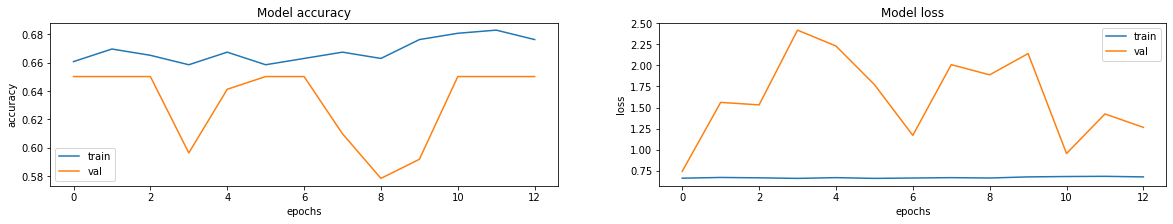

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history['accuracy'])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

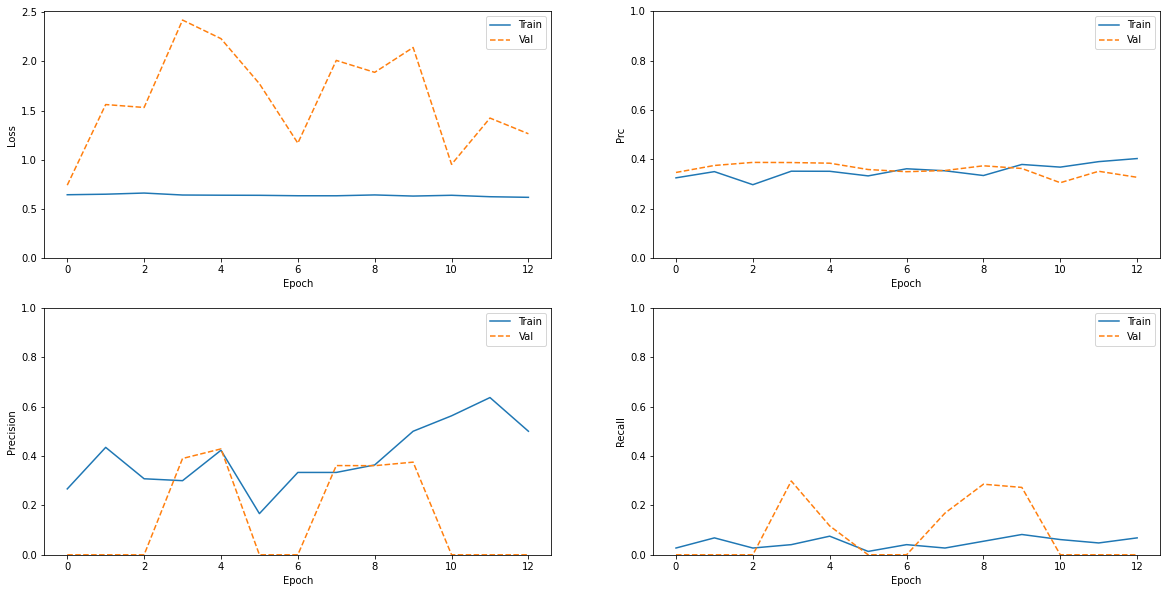

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.ravel()
plot_metrics(model.history)

### Understanding useful metrics


*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds. 

Note: Accuracy is not a helpful metric for this task. A 99.8%+ accuracy can be gotten by predicting False all the time.  

loss :  1.5312552452087402
tp :  0.0
fp :  1.0
tn :  145.0
fn :  77.0
accuracy :  0.6502242088317871
precision :  0.0
recall :  0.0
auc :  0.5668920278549194
prc :  0.38808467984199524

True Negatives (TN):  145
False Positives (FP):  1
False Negatives (FN):  77
True Positives (TP):  0
Total:  77


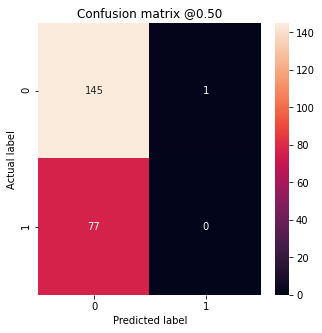

In [27]:
train_predictions_baseline = model.predict(X_train, batch_size=batch_size)
test_predictions_baseline = model.predict(X_test, batch_size=batch_size)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives (TN): ', cm[0][0])
  print('False Positives (FP): ', cm[0][1])
  print('False Negatives (FN): ', cm[1][0])
  print('True Positives (TP): ', cm[1][1])
  print('Total: ', np.sum(cm[1]))



baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)



If the model had predicted everything perfectly, the confusion matrix above  would be a diagonal matrix where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that the model is predicting only for the 0 class as there are no true positives nor false positives. This explains why the model had a non changing training accuracy. 

### Calculate class weights

In [28]:
# Scaling by total/2.0
# The sum of the weights of all examples stays the same.
total = num_zeros_class + num_ones_class
weight_for_0 = (1 / num_zeros_class) * (total / 2.0)
weight_for_1 = (1 / num_ones_class) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.75
Weight for class 1: 1.51


In [29]:
# Build new model.
weighted_model = get_model(width=128, height=128, depth=64)
weighted_model.layers[-1].bias.assign([0.0])

weighted_history = weighted_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=10,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb],
    class_weight=class_weight) 




Epoch 1/100
91/91 [==============================] - 29s 299ms/step - loss: 0.7188 - tp: 58.0000 - fp: 136.0000 - tn: 169.0000 - fn: 88.0000 - accuracy: 0.5033 - precision: 0.2990 - recall: 0.3973 - auc: 0.4767 - prc: 0.3069 - val_loss: 1.1372 - val_tp: 30.0000 - val_fp: 47.0000 - val_tn: 99.0000 - val_fn: 47.0000 - val_accuracy: 0.5785 - val_precision: 0.3896 - val_recall: 0.3896 - val_auc: 0.5421 - val_prc: 0.3748
Epoch 2/100
91/91 [==============================] - 26s 289ms/step - loss: 0.7041 - tp: 54.0000 - fp: 114.0000 - tn: 191.0000 - fn: 92.0000 - accuracy: 0.5432 - precision: 0.3214 - recall: 0.3699 - auc: 0.5257 - prc: 0.3537 - val_loss: 1.3368 - val_tp: 30.0000 - val_fp: 47.0000 - val_tn: 99.0000 - val_fn: 47.0000 - val_accuracy: 0.5785 - val_precision: 0.3896 - val_recall: 0.3896 - val_auc: 0.5451 - val_prc: 0.3699
Epoch 3/100
91/91 [==============================] - 26s 288ms/step - loss: 0.7197 - tp: 67.0000 - fp: 147.0000 - tn: 158.0000 - fn: 79.0000 - accuracy: 0.4989 

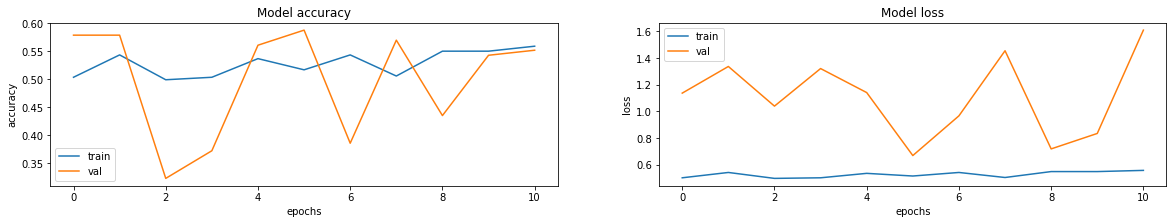

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(weighted_history.history['accuracy'])
    ax[i].plot(weighted_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Check training history

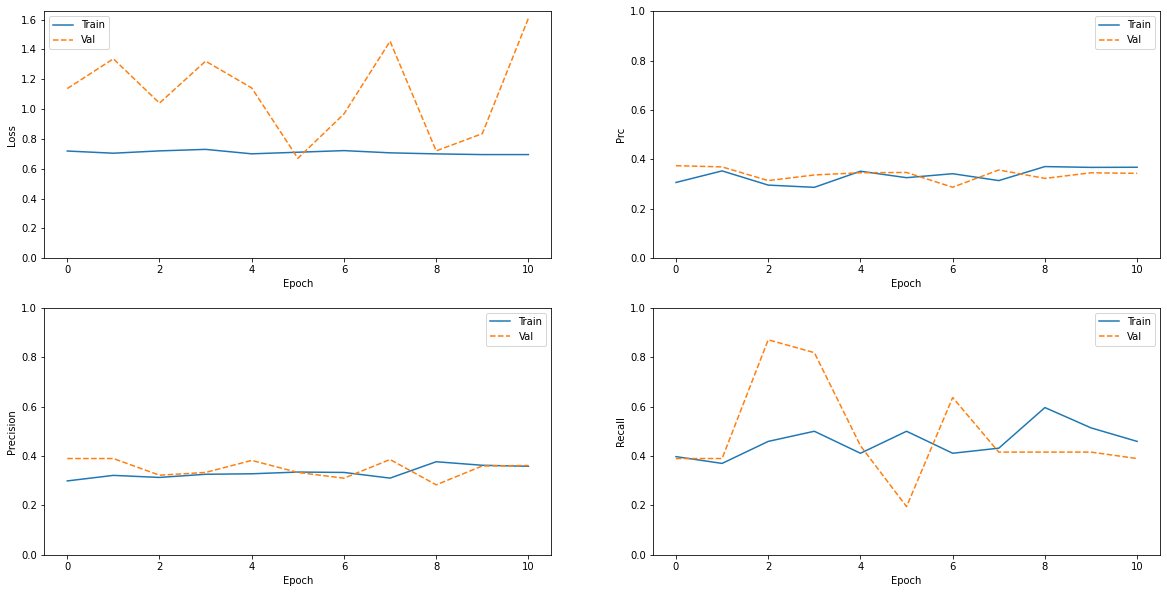

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.ravel()
plot_metrics(weighted_history)

### Evaluate metrics

In [32]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=batch_size)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=batch_size)

45/45 [==============================] - 4s 77ms/step - loss: 1.1372 - tp: 30.0000 - fp: 47.0000 - tn: 99.0000 - fn: 47.0000 - accuracy: 0.5785 - precision: 0.3896 - recall: 0.3896 - auc: 0.5421 - prc: 0.3748
loss :  1.1371577978134155
tp :  30.0
fp :  47.0
tn :  99.0
fn :  47.0
accuracy :  0.5784753561019897
precision :  0.3896103799343109
recall :  0.3896103799343109
auc :  0.5421187877655029
prc :  0.3747805953025818

True Negatives (TN):  99
False Positives (FP):  47
False Negatives (FN):  47
True Positives (TP):  30
Total:  77


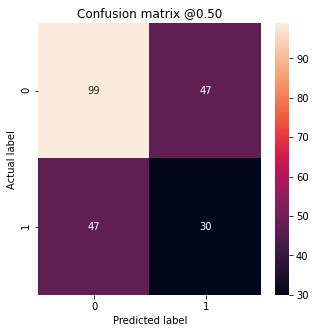

In [33]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=batch_size, verbose=1)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)